In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
from src.imu import Imu
import pandas as pd
import numpy as np
import xarray as xr
import cv2
from scipy import stats
from datetime import datetime

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Timestamp read-in

In [4]:
def read_timestamp_series(s):
    output_time = []
    fmt = '%H:%M:%S.%f'
    if s.dtype != np.float64:
        for current_time in s:
            str_time = str(current_time).strip()
            try:
                t = datetime.strptime(str_time, fmt)
            except ValueError as v:
                ulr = len(v.args[0].partition('unconverted data remains: ')[2])
                if ulr:
                    str_time = str_time[:-ulr]
            try:
                output_time.append((datetime.strptime(str_time, '%H:%M:%S.%f') - datetime.strptime('00:00:00.000000', '%H:%M:%S.%f')).total_seconds())
            except ValueError:
                output_time.append(np.nan)
        output_time = np.array(output_time)
    else:
        output_time = s.values
    return output_time

def read_timestamp_file(path):
    # read data and set up format
    s = pd.read_csv(path, encoding='utf-8', engine='c', header=None).squeeze()
    if s[0] == 0:
        s = s[1:]
    camT = read_timestamp_series(s)
    return camT

# Ephys vs. IMU onset timing

## Preprocess IMU

In [ ]:
config = {
    'internals': {
        'flip_gyro_xy': False,
        'imu_dwnsmpl': 100,
        'imu_samprate': 30000
    }
}
recording_name = '051822_test_control_Rig2_fm1'
recording_path = '/home/niell_lab/Data/freely_moving_ephys/testing/test/fm1'

imu = Imu(config, recording_name, recording_path)
imu.process()

## Read in Ephys

In [ ]:
ephys_bin_path = '/home/niell_lab/Data/freely_moving_ephys/testing/test/fm1/051822_test_control_Rig2_fm1_Ephys.bin'
num_ch = 64
# set up data types to read binary file into
dtypes = np.dtype([('ch'+str(i),np.uint16) for i in range(0,num_ch)])
# read in binary file
ephys = pd.DataFrame(np.fromfile(ephys_bin_path, dtypes, -1, ''))

In [ ]:
imu_file = '/home/niell_lab/Data/freely_moving_ephys/testing/test/fm1/051822_test_control_Rig2_fm1_imu.nc'
imu_data = xr.open_dataset(imu_file)
imuT = imu_data.__xarray_dataarray_variable__.sample.values

In [ ]:
time_path = '/home/niell_lab/Data/freely_moving_ephys/testing/test/fm1/051822_test_control_Rig2_fm1_Ephys_BonsaiBoardTS.csv'
ephysT = read_timestamp_file(time_path)

In [ ]:
t0 = ephysT[0]
t_end = ephysT[-1] - t0

In [ ]:
new_imuT = imuT - t0

In [ ]:
gyro_x = imu_data.__xarray_dataarray_variable__.sel(channel='gyro_x').values

In [ ]:
ephys_timerange = np.linspace(0, t_end, np.size(ephys,0))

In [ ]:
new_ephys = interp1d(ephys_timerange, ephys, axis=0, bounds_error=False)(new_imuT)#, bounds_error=False)()

In [ ]:
new_ephys.shape

In [ ]:
float(new_imuT[np.argwhere((np.diff(new_ephys[:, 0])>500))[0]])

In [ ]:
ephys_offset = 0.1
ephys_drift_rate = -0.000114

In [ ]:
imuTc1 = new_imuT - (ephys_offset + new_imuT * ephys_drift_rate)

In [ ]:
start = 2500
stop = 3000

imuTc = new_imuT.copy()[start:stop] #imuTc1.copy()[start:stop]

ephys_onset = float(imuTc[np.argwhere((np.diff(new_ephys[start:stop, 0])>10000))[0]])
imu_onset = float(imuTc[np.argwhere((np.diff(gyro_x[start:stop])>100))[0]])

plt.subplots(2,1,figsize=(8,6))

plt.subplot(211)
plt.plot(imuTc, new_ephys[start:stop, 0], color='k')
plt.title('ephys (ch=0), onset={} msec'.format(np.round((ephys_onset)*1000,1)))
plt.xticks(np.linspace(imuTc[0], imuTc[-1], 10),
           labels=np.linspace(0, (imuTc[-1] - imuTc[0])*1000, 10).astype(int))
plt.vlines(ephys_onset, np.min(new_ephys[start:stop, 0]), np.max(new_ephys[start:stop, 0]))

plt.subplot(212)
plt.plot(imuTc, gyro_x[start:stop], color='k')
plt.title('gyro x, onset={} msec'.format(np.round((imu_onset)*1000,1)))
plt.xticks(np.linspace(imuTc[0], imuTc[-1], 10),
           labels=np.linspace(0, (imuTc[-1] - imuTc[0])*1000, 10).astype(int))
plt.xlabel('msec')
plt.vlines(imu_onset, np.min(gyro_x[start:stop]), np.max(gyro_x[start:stop]))

plt.tight_layout()

In [ ]:
ephys_timerange = np.linspace(0, t_end, np.size(ephys,0))

In [ ]:
# start = int(7500/100)
# stop = 4000

# imuTc = imuTc1.copy()[start:stop]

# ephys_onset = float(imuTc[np.argwhere((np.diff(new_ephys[start:stop, 0])>10000))[0]])
# imu_onset = float(imuTc[np.argwhere((np.diff(gyro_x[start:stop])>100))[0]])

plt.subplots(2,1,figsize=(8,6))

plt.subplot(211)
plt.plot(imuTc, new_ephys[start:stop, 0], color='k')
plt.title('ephys (ch=0), onset={} msec'.format(np.round((ephys_onset)*1000,1)))
plt.xticks(np.linspace(imuTc[0], imuTc[-1], 10),
           labels=np.linspace(0, (imuTc[-1] - imuTc[0])*1000, 10).astype(int))
plt.vlines(ephys_onset, np.min(new_ephys[start:stop, 0]), np.max(new_ephys[start:stop, 0]))

plt.subplot(212)
plt.plot(imuTc, gyro_x[start:stop], color='k')
plt.title('gyro x, onset={} msec'.format(np.round((imu_onset)*1000,1)))
plt.xticks(np.linspace(imuTc[0], imuTc[-1], 10),
           labels=np.linspace(0, (imuTc[-1] - imuTc[0])*1000, 10).astype(int))
plt.xlabel('msec')
plt.vlines(imu_onset, np.min(gyro_x[start:stop]), np.max(gyro_x[start:stop]))

plt.tight_layout()

In [ ]:
((imu_onset-imuTc[0]) - (ephys_onset-imuTc[0]))*1000

In [ ]:
imu_bin_path = '/home/niell_lab/Data/freely_moving_ephys/testing/test/fm1/051822_test_control_Rig2_fm1_IMU.bin'

In [ ]:
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16),
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16)
])
# read in binary file
data = pd.DataFrame(np.fromfile(imu_bin_path, dtypes, -1, ''))
data = data.to_numpy()

In [ ]:
ephys = ephys.to_numpy()

In [ ]:
ephys.shape

In [ ]:
start = 240000#int(1e5)
stop = start+100000 #int(1.5e5)

# ephys_onset = float(new_imuT[np.argwhere((np.diff(new_ephys[:, 0])>500))[0]])
# imu_onset = float(new_imuT[np.argwhere((np.diff(gyro_x[:])>50))[0]])

plt.subplots(2,1,figsize=(8,6))

plt.subplot(211)
plt.plot(ephys[start:stop, 0], color='k')
# plt.title('ephys (ch=0), onset={} msec'.format(np.round((ephys_onset-new_imuT[start])*1000,1)))
# plt.xticks(np.linspace(new_imuT[start], new_imuT[stop], 8),
#            labels=np.linspace(0, (new_imuT[stop] - new_imuT[start])*1000, 8).astype(int))
# plt.vlines(ephys_onset, np.min(new_ephys[start:stop, 0]), np.max(new_ephys[start:stop, 0]))

plt.subplot(212)
plt.plot(data[start:stop, 4], color='k')
# plt.title('gyro x, onset={} msec'.format(np.round((imu_onset-new_imuT[start])*1000,1)))
# plt.xticks(np.linspace(new_imuT[start], new_imuT[stop], 8),
#            labels=np.linspace(0, (new_imuT[stop] - new_imuT[start])*1000, 8).astype(int))
# plt.xlabel('msec')
# plt.vlines(imu_onset, np.min(gyro_x[start:stop]), np.max(gyro_x[start:stop]))

plt.tight_layout()

In [ ]:
plt.plot()

# Checkerboard timing using worldcam vs. TTL

In [ ]:
rec_path = '/home/niell_lab/Data/freely_moving_ephys/ephys_recordings/041422/J599RT/hf1_revchecker500ms'
imu_bin = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_IMU.bin')
world_nc = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_world.nc')
ephys_csv = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_Ephys_BonsaiBoardTS.csv')

In [ ]:
Rc_world = xr.open_dataset(world_nc)

In [ ]:
vid = Rc_world.WORLD_video.values.astype(np.uint8)

In [ ]:
worldT = Rc_world.timestamps.values

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))

In [ ]:
eventT = worldT[np.where((label_diff<-0.1)+(label_diff>0.1))]

In [ ]:
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16),
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16)
])
# read in binary file
data = pd.DataFrame(np.fromfile(imu_bin, dtypes, -1, ''))
data = data.to_numpy()
ttl_onset = data[:,3].copy()
ttl_on = data[:,7].copy()

In [ ]:
onset = ttl_onset - np.median(ttl_onset)
onsetInd = np.argwhere(np.diff(onset)>1e4).flatten()

In [ ]:
onsetInd1 = onsetInd.copy()
onsetInd1 = onsetInd1[np.argwhere((np.diff(onsetInd1)>1)).flatten()]

In [ ]:
# read in timestamps
csv_data = pd.read_csv(ephys_csv).squeeze()
pdtime = pd.DataFrame(read_timestamp_series(csv_data))
# get first/last timepoint, num_samples
t0 = pdtime.iloc[0,0]; num_samp = np.size(data,0)
samp_freq = 30000
# samples start at t0, and are acquired at rate of 'ephys_sample_rate'/ 'imu_downsample'
newtime = np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq)

In [ ]:
ephys_offset = 0.1
ephys_drift_rate = -0.000114
newtime = newtime - newtime[0]
newtime1 = newtime - (ephys_offset + newtime * ephys_drift_rate)

In [ ]:
worldT = worldT - t0

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(newtime1-newtime1[0], ttl_onset-np.median(ttl_onset), '-')
plt.plot(worldT-newtime1[0], labels*60000, '-')
plt.xlim([300, 303])

In [ ]:
onset_from_ttl = newtime[onsetInd1].copy()
onset_from_worldcam = eventT.copy()

In [ ]:
best_match = np.zeros(onset_from_worldcam.size)
for wcI, wcT in enumerate(onset_from_worldcam):
    best_match[wcI] = onset_from_ttl[np.argmin(np.abs(onset_from_ttl-wcT))]

In [ ]:
delay_after_ttl = best_match - onset_from_worldcam
delay_after_ttl = (delay_after_ttl * 1000)

In [ ]:
onset_from_ttl.shape

In [ ]:
plt.subplots(2,1,figsize=(4,6))

plt.subplot(211)
plt.hist(np.diff(onset_from_ttl)*1000, bins=np.arange(500,570,2))
plt.xlim([500,560])
plt.title('TTL')

plt.subplot(212)
plt.hist(np.diff(onset_from_worldcam)*1000, bins=np.arange(500,570,2))
plt.xlim([500,560])
plt.title('Worldcam')

plt.tight_layout()

In [ ]:
plt.subplots(2,1,figsize=(4,6))

plt.subplot(211)
plt.plot(np.diff(onset_from_ttl)*1000)
plt.xlim([0,120]); plt.ylim([510,550])
plt.title('TTL')
plt.ylabel('flip diff (msec)'); plt.xlabel('sample')

plt.subplot(212)
plt.plot(np.diff(onset_from_worldcam)*1000)
plt.xlim([0,120]); plt.ylim([510,550])
plt.title('Worldcam')
plt.ylabel('flip diff (msec)'); plt.xlabel('sample')

plt.tight_layout()

In [ ]:
plt.plot(onset_from_worldcam[:-20], delay_after_ttl[:-20], 'k')
plt.ylabel('delay after ttl (msec)'); plt.xlabel('time of flip')
# plt.ylim([100, -100])

In [ ]:
res = stats.linregress(onset_from_worldcam[:-20], delay_after_ttl[:-20])

In [ ]:
res

In [ ]:
res.slope

# LFP vs. spikeT from ephys analysis

In [ ]:
import json

In [ ]:
ephys_df = pd.read_hdf('/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_ephys_props.h5')

In [ ]:
ephys_bin_path = '/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_Ephys.bin'

In [ ]:
channel_map_path = '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/config/channel_maps.json'

In [ ]:
ephys_timepath = '/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_Ephys_BonsaiBoardTS.csv'
ephysT = read_timestamp_file(ephys_timepath)
t0 = ephysT[0]

In [ ]:
num_ch = 128
# set up data types to read binary file into
dtypes = np.dtype([('ch'+str(i),np.uint16) for i in range(0,num_ch)])
# read in binary file
ephys = pd.DataFrame(np.fromfile(ephys_bin_path, dtypes, -1, ''))

# open channel map file
with open(channel_map_path, 'r') as fp:
    all_maps = json.load(fp)
# get channel map for the current probe
ch_map = all_maps['DB_P128-6']
# remap with known order of channels
ephys = ephys.iloc[:,[i-1 for i in list(ch_map)]]

In [ ]:
ephys = ephys.to_numpy()

In [ ]:
ephys_df.index.values

In [ ]:
ind = 31
spikeT = ephys_df.loc[ind, 'spikeT']

In [ ]:
spikeT.shape

In [ ]:
ephys_df.loc[ind, 'ch']

In [ ]:
num_samp = np.size(ephys,0)
samp_freq = 30000
# samples start at t0, and are acquired at rate of 'ephys_sample_rate'/ 'imu_downsample'
newtime = np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq)

In [ ]:
newtime.shape

In [ ]:
lfp.shape

In [ ]:
lfp = ephys[:, 6].copy()

In [ ]:
ephys_offset = 0.1
ephys_drift_rate = -0.000114
newtime = newtime - newtime[0]
newtime1 = newtime - (ephys_offset + newtime * ephys_drift_rate)

In [ ]:
plt.figure(figsize=(9,9))
plt.vlines(spikeT, 3000, 32000, color='r')
plt.plot(newtime1, lfp, '-')
plt.xlim([14.56,14.57])
plt.ylim([30000,32000])

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(spikeT, 32000*np.ones(len(spikeT)), 'r*')
plt.plot(newtime1, lfp, '-')
plt.xlim([27,27.2])
# plt.ylim([30000,32000])

In [ ]:
a = np.zeros(len(lfp))

In [ ]:
spikeInd = np.zeros(len(spikeT))
for i,t in enumerate(spikeT):
    spikeInd[i] = np.argmin(np.abs(newtime1-t))

In [ ]:
a[spikeInd.astype(int)] = 1

In [ ]:
from src.utils.correlation import nanxcorr

In [ ]:
use_lfp = np.zeros([len(spikeInd),2000])
for i, t in enumerate(spikeInd):
    use_lfp[i] = lfp[(t.astype(int)-1000):(t.astype(int)+1000)]

In [ ]:
for i in range(np.size(use_lfp,0)):
    plt.plot(use_lfp[i,:]-np.median(use_lfp[i,:]), '-')

In [ ]:
plt.plot(np.mean(use_lfp,0))
plt.xlim([900,1100])
plt.vlines(1000,32000,32800,'k')

In [ ]:
200/30000

# LFP vs. spike raster from filtered LFP

In [ ]:
from scipy.signal import butter, sosfiltfilt

In [ ]:
ephys_timepath = '/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_Ephys_BonsaiBoardTS.csv'
ephysT = read_timestamp_file(ephys_timepath)
t0 = ephysT[0]

In [ ]:
def butter_bandpass(lfp, lowcut=1, highcut=300, fs=30000, order=5):
    nyq = 0.5 * fs # Nyquist frequency
    low = lowcut / nyq # low cutoff
    high = highcut / nyq # high cutoff
    sos = butter(order, [low, high], btype='bandpass', output='sos')
    filt = sosfiltfilt(sos, lfp, axis=0)
    return filt

In [ ]:
lfp_ephys = ephys.copy()

In [ ]:
ephys_center_sub = lfp_ephys - np.mean(lfp_ephys, 0)
filt_ephys = butter_bandpass(ephys_center_sub, order=6)

In [ ]:
filt_ephys.shape

In [ ]:
num_samp = np.size(ephys,0)
samp_freq = 30000
# samples start at t0, and are acquired at rate of 'ephys_sample_rate'/ 'imu_downsample'
newtime = np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq)

In [ ]:
ephys_offset = 0.1
ephys_drift_rate = -0.000114
newtime = newtime - newtime[0]
newtime1 = newtime - (ephys_offset + newtime * ephys_drift_rate)

In [ ]:
world_nc = '/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_world.nc'
Rc_world = xr.open_dataset(world_nc)
vid = Rc_world.WORLD_video.values.astype(np.uint8)
worldT = Rc_world.timestamps.values

In [ ]:
worldT = read_timestamp_file('/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_WORLD_BonsaiTS.csv')

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))

In [ ]:
eventT = worldT[np.where((label_diff<-0.1)+(label_diff>0.1))]

In [ ]:
vidread = cv2.VideoCapture('/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_WORLD.avi')
world_vid = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                    int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)*0.25),
                    int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH)*0.25)], dtype=np.uint8)
# iterate through each frame
for frame_num in range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT))):
    # read the frame in and make sure it is read in correctly
    ret, frame = vidread.read()
    if not ret:
        break
    # convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # downsample the frame by an amount specified in the config file
    sframe = cv2.resize(frame, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
    # add the downsampled frame to all_frames as int8
    world_vid[frame_num,:,:] = sframe.astype(np.int8)

In [ ]:
world_vid.shape

In [ ]:
from tqdm import tqdm

# get approx. spike times out of LFP

In [ ]:
cam_gamma = 2
world_norm = (world_vid/255)**cam_gamma
std_im = np.std(world_norm,axis=0)
std_im[std_im<10/255] = 10/255
img_norm = (world_norm-np.mean(world_norm,axis=0))/std_im
img_norm = img_norm * (std_im>20/255)
img_norm[img_norm<-2] = -2
movInterp = interp1d(worldT, img_norm, axis=0, bounds_error=False)
all_spikeT = []
for ch in tqdm(range(np.size(filt_ephys,1))):
    spike_thresh = -350 # 350
    spike_inds = list(np.where(filt_ephys[:,ch] < spike_thresh)[0])
    spikeT = newtime[spike_inds]
    all_spikeT.append(spikeT - (ephys_offset + spikeT * ephys_drift_rate))

In [ ]:
len(all_spikeT[45])

In [ ]:
flip = eventT[3] - t0
flip

In [ ]:
flipInd = np.argmin(np.abs(flip-(newtime1)))
flipInd

In [ ]:
use = eventT.copy()
use = use - t0
use = use[use>szT]
use = use[:2000]

In [ ]:
5000*(1/30000)

In [ ]:
filt_ephys.shape

In [ ]:
ephys_df.index.values

In [ ]:
ephys_df[ephys_df['ch']==1].index.values

In [ ]:
unit = 7 # 71, 32, 338
ch = int(ephys_df.loc[unit, 'ch'])

sz = 5000
szT = np.median(np.diff(newtime1))*(sz*2)

plot_lfp = np.zeros([use.size, sz*2])

sp = all_spikeT[ch].copy()
sp1 = ephys_df.loc[unit, 'spikeT'].copy()

fig, [ax0, ax1, ax2] = plt.subplots(3,1,figsize=(4,6), dpi=300)

for i, f in enumerate(use):
    ind = np.argmin(np.abs(f-(newtime1)))
    startInd = ind-sz; endInd = ind+sz
    startT = f-szT; endT = f+szT
    
    plot_lfp[i,:] = filt_ephys[startInd:endInd, ch].copy()
    # ax0.plot(plot_lfp[i,:], linewidth=1, alpha=0.5)
    
    # raster
    ax1.vlines(sp[(sp>startT) & (sp<endT)]-f, i-0.25, i+0.25)
    
    ax2.vlines(sp1[(sp1>startT) & (sp1<endT)]-f, i-0.25, i+0.25)
    
ax1.vlines(0, 0, 120, 'k')
ax1.set_xlim([-.3,.3])
ax1.set_xlabel('sec')
ax1.set_ylabel('flip')

ax2.vlines(0, 0, 120, 'k')
ax2.set_xlim([-.3,.3])
ax2.set_xlabel('sec')
ax2.set_ylabel('flip')

ax0.set_title('LFP')
ax1.set_title('spikeT from LFP')
ax2.set_title('spikeT from ephys analysis')

cent = np.mean(plot_lfp)
# ax0.set_ylim([cent-500, cent+500])
ax0.plot(np.mean(plot_lfp,0), 'k', linewidth=4)
# ax0.vlines(5000,-2000,2000,'k')
ax0.set_xticks(np.linspace(0, sz*2, 7), labels=np.round(np.arange(-0.3, 0.4, 0.1), 1))
ax0.set_xlim([0,sz*2])

fig.tight_layout()

In [ ]:
[x for x in ephys_df.columns if 'um' in x]

In [ ]:
ephys_df.loc[7, 'depth']

In [ ]:
np.round(np.arange(-0.3, 0.4, 0.1), 1)

In [ ]:
plot_lfp.shape

In [ ]:
sp = all_spikeT[ch].copy()
spcrop = sp[(sp>startT) & (sp<endT)]

In [ ]:
endT

In [ ]:
startT

In [ ]:
szT

In [ ]:
ind

In [ ]:
endInd

In [ ]:
startInd

In [ ]:
sp[(sp>startT) & (sp<endT)]

# LFP and spikeT aligned to flips from TTL and worldcam

In [9]:
rec_path = '/home/niell_lab/Data/freely_moving_ephys/ephys_recordings/041422/J599RT/hf1_revchecker500ms'
imu_bin = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_IMU.bin')
ephys_bin = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_Ephys.bin')
world_nc = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_world.nc')
ephys_csv = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_Ephys_BonsaiBoardTS.csv')
ephys_json = os.path.join(rec_path, '041422_J599RT_control_Rig2_hf1_revchecker500ms_ephys_merge.json')

## worldcam

In [6]:
Rc_world = xr.open_dataset(world_nc)
vid = Rc_world.WORLD_video.values.astype(np.uint8)
worldT = Rc_world.timestamps.values

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))

In [ ]:
eventT = worldT[np.where((label_diff<-0.1)+(label_diff>0.1))]

## spike sorted ephys

In [7]:
import json
with open(ephys_json, 'r') as fp:
    spikes_json = json.load(fp)

In [8]:
spikes_json.keys()

dict_keys(['Amplitude', 'ContamPct', 'KSLabel', 'amp', 'ch', 'depth', 'fr', 'group', 'n_spikes', 'sh', 'waveform', 'spikeT', 't0'])

In [ ]:
spikeT = {}; chan = {}; f_rate = {}
for i, ind in enumerate(spikes_json['spikeT'].keys()):
    if spikes_json['KSLabel'][ind]=='good':
        spikeT[int(ind)] = spikes_json['spikeT'][ind]
        chan[int(ind)] = spikes_json['ch'][ind]
        f_rate[int(ind)] = spikes_json['fr'][ind]

In [ ]:
# time drift correction
ephys_offset = 0.1
ephys_drift_rate = -0.000114

for ch in spikeT.keys():
    sp = np.array(spikeT[ch])
    spikeT[ch] = sp - (ephys_offset + sp * ephys_drift_rate)

## ephys

In [10]:
from scipy.signal import butter, sosfiltfilt

In [11]:
ephysT = read_timestamp_file(ephys_csv)
t0 = ephysT[0]

In [12]:
def butter_bandpass(lfp, lowcut=1, highcut=300, fs=30000, order=5):
    nyq = 0.5 * fs # Nyquist frequency
    low = lowcut / nyq # low cutoff
    high = highcut / nyq # high cutoff
    sos = butter(order, [low, high], btype='bandpass', output='sos')
    filt = sosfiltfilt(sos, lfp, axis=0)
    return filt

In [13]:
num_ch = 128
# set up data types to read binary file into
dtypes = np.dtype([('ch'+str(i),np.uint16) for i in range(0,num_ch)])
# read in binary file
ephys = pd.DataFrame(np.fromfile(ephys_bin, dtypes, -1, '')).to_numpy().astype(np.int64)

In [14]:
ephys = ephys - np.mean(ephys, 0)

In [39]:
filtspikes = butter_bandpass(ephys, lowcut=800, highcut=8000, fs=30000, order=6)

In [71]:
filtlfp = butter_bandpass(ephys, order=6)

In [15]:
# read in timestamps
csv_data = pd.read_csv(ephys_csv).squeeze()
pdtime = pd.DataFrame(read_timestamp_series(csv_data))
# get first/last timepoint, num_samples
t0 = pdtime.iloc[0,0]; num_samp = np.size(filtephys,0)
samp_freq = 30000
# samples start at t0, and are acquired at rate of 'ephys_sample_rate'/ 'imu_downsample'
newtime = np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq)

In [16]:
ephys_offset = 0.1
ephys_drift_rate = -0.000114
newtime = newtime - newtime[0]
newtime1 = newtime - (ephys_offset + newtime * ephys_drift_rate)

In [18]:
from tqdm import tqdm

In [42]:
lfp_spikeT = []
for ch in tqdm(range(np.size(filtephys,1))):
    spike_thresh = -350 # 350
    spike_inds = list(np.where(filtephys[:,ch] < spike_thresh)[0])
    sp = newtime1[spike_inds]
    lfp_spikeT.append(sp)
    # lfp_spikeT.append(sp - (ephys_offset + sp * ephys_drift_rate))

100%|█████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 82.65it/s]


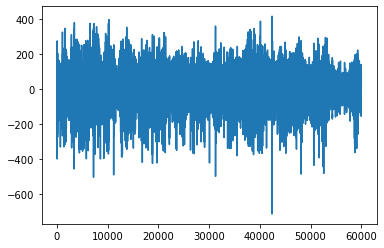

In [41]:
plt.plot(filtephys[:60000,0])

In [33]:
len(lfp_spikeT[0])

1447136

In [35]:
lfp_spikeT[0][:20]

array([-0.03162554, -0.0315922 , -0.03155887, -0.03152553, -0.03149219,
       -0.03145885, -0.03142552, -0.03139218, -0.03135884, -0.03132551,
       -0.03129217, -0.03125883, -0.03122549, -0.03119216, -0.03115882,
       -0.03112548, -0.03109215, -0.03105881, -0.03102547, -0.03099213])

In [21]:
len(newtime1)

9326592

## spikes from lfp

In [ ]:
# all_spikeT = []
# for ch in range(np.size(filt_ephys,1)):
#     spike_thresh = -350 # 350
#     spike_inds = list(np.where(filt_ephys[:,ch] < spike_thresh)[0])
#     spikeT = newtime1[spike_inds]
    # all_spikeT.append(spikeT - (ephys_offset + spikeT * ephys_drift_rate))

## TTL

In [43]:
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16),
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16)
])
# read in binary file
ttl = pd.DataFrame(np.fromfile(imu_bin, dtypes, -1, '')).to_numpy()
ttl_onset = ttl[:,3].copy()
ttl_on = ttl[:,7].copy()

In [44]:
onset = ttl_onset - np.median(ttl_onset)
onsetInd = np.argwhere(np.diff(onset)>1e4).flatten()

In [45]:
onsetInd1 = onsetInd.copy()
onsetInd1 = onsetInd1[np.argwhere((np.diff(onsetInd1)>1)).flatten()]

In [46]:
onset_from_ttl = newtime1[onsetInd1].copy()

In [63]:
sz = 0.2*30000
ch = 26

lfp_around_ttl = np.zeros([onset_from_ttl.size, int(sz*2)])

for i, t in enumerate(onset_from_ttl):
    ind = np.argmin(np.abs(t-(newtime1)))
    startInd = int(ind-sz); endInd = int(ind+sz)
    
    lfp_around_ttl[i,:] = filtephys[startInd:endInd, ch]

KeyboardInterrupt: 

# Get the mean LFP around each TTL onset for all units!

In [ ]:
sz = 0.2*30000

all_lfp_around_ttl = np.zeros([128, int(sz*2)])

for ch in tqdm(range(128)):
    lfp_around_ttl = np.zeros([onset_from_ttl.size, int(sz*2)])
    for i, t in enumerate(onset_from_ttl):
        ind = np.argmin(np.abs(t-(newtime1)))
        startInd = int(ind-sz); endInd = int(ind+sz)

        lfp_around_ttl[i,:] = filtlfp[startInd:endInd, ch]
    
    all_lfp_around_ttl[ch,:] = np.nanmean(lfp_around_ttl, 0)
    

 30%|██████████████████▉                                           | 39/128 [11:11<25:28, 17.18s/it]

(-0.1, 0.2)

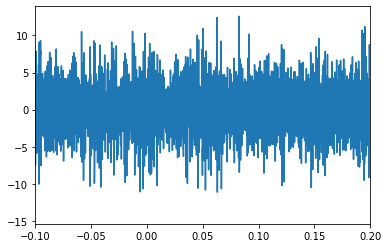

In [70]:
plt.plot(np.linspace(-.25, .25, 12000), all_lfp_around_ttl[0,:])
plt.xlim([-0.1,0.2])

(-0.2, 0.2)

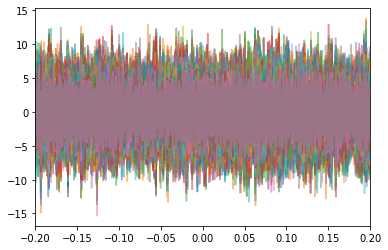

In [67]:
for i in range(128):
    plt.plot(np.linspace(-.25, .25, 12000), all_lfp_around_ttl[i,:], alpha=0.5)
plt.xlim([-0.2,0.2])

In [ ]:
sz = 0.2*30000
ch = 26
onset_arr = ttl_onset-np.median(ttl_onset)
wc_flipT = (eventT-t0)+(np.median(np.diff(worldT))/2)
wc_flipT = eventT-t0

lfp_around_wc = np.zeros([eventT.size, int(sz*2)])
ttl_around_wc = np.zeros([eventT.size, int(sz*2)])

for i, t in enumerate(wc_flipT):
    ind = np.argmin(np.abs(t-(newtime1)))
    startInd = int(ind-sz)
    endInd = int(ind+sz)
    if (endInd > np.size(filtephys, 0)) or (startInd < 0):
        lfp_around_wc[i,:] = np.nan
        ttl_around_wc[i,:] = np.nan
    else:
        lfp_around_wc[i,:] = filtephys[startInd:endInd, ch]
        ttl_around_wc[i,:] = onset_arr[startInd:endInd]

In [ ]:
# mean_lfp_around_ttl = np.mean(lfp_around_ttl, 0)
mean_lfp_around_wc = np.nanmean(lfp_around_wc, 0)
mean_ttl_around_wc = np.nanmean(ttl_around_wc, 0)

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(mean_lfp_around_wc*25, label='lfp')
plt.plot(mean_ttl_around_wc, label='ttl')
plt.vlines(6000, -2000, 2000, 'k')
plt.xticks(np.linspace(0, 12000, 7), np.round(np.linspace(-.2, 0.2, 7),2))

## fig

In [ ]:
cell = 49
ch = chan[cell]

sz = 5000
szT = np.median(np.diff(newtime1))*(sz*2)

sp = spikeT[cell].copy()

fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2,2,figsize=(4,3), dpi=300)

for i, f in enumerate(eventT-t0):
    ind = np.argmin(np.abs(f-(newtime1)))
    startInd = ind-sz; endInd = ind+sz
    startT = f-szT; endT = f+szT
    
    # raster
    ax1.vlines(sp[(sp>startT) & (sp<endT)]-f, i-0.25, i+0.25)
# LFP
ax0.plot(np.linspace(-.25, .25, 12000), mean_lfp_around_wc, linewidth=1, alpha=0.5)

ax0.set_title('LFP (around wc)')
ax0.vlines(0, -100, 100, 'k')
ax0.set_xlabel('sec')

ax1.set_title('LFP spikeT (around wc)')
ax1.vlines(0, 0, np.size(eventT,0), 'k')
ax1.set_xlim([-.25,.25])
ax1.set_xlabel('sec')
ax1.set_ylabel('flip')

#####
for i, f in enumerate(onset_from_ttl):
    ind = np.argmin(np.abs(f-(newtime1)))
    startInd = ind-sz; endInd = ind+sz
    startT = f-szT; endT = f+szT
    
    # raster
    ax3.vlines(sp[(sp>startT) & (sp<endT)]-f, i-0.25, i+0.25)
# LFP
ax2.plot(np.linspace(-.25, .25, 12000), mean_lfp_around_ttl, linewidth=1, alpha=0.5)
ax2.set_title('LFP (around TTL)')
ax2.vlines(0, -100, 100, 'k')
ax2.set_xlabel('sec')

ax3.set_title('LFP spikeT (around TTL)')
ax3.vlines(0, 0, np.size(onset_from_ttl,0), 'k')
ax3.set_xlim([-.25,.25])
ax3.set_xlabel('sec')
ax3.set_ylabel('flip')

fig.tight_layout()

In [48]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

In [49]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]

    return sdf

In [53]:
len(lfp_spikeT[0])

20325

In [ ]:
for t in onset_from_ttl:
    

In [54]:
all_psth = np.zeros([len(lfp_spikeT), 2001])
for i, ch in tqdm(enumerate(range(len(lfp_spikeT)))):
    sp = lfp_spikeT[ch]
    all_psth[i,:] = calc_kde_sdf(sp, onset_from_ttl)

128it [03:24,  1.60s/it]


In [55]:
psth_bins = np.arange(-1,1.001,1/1000)

In [59]:
all_psth.shape

(128, 2001)

In [60]:
128/10

12.8

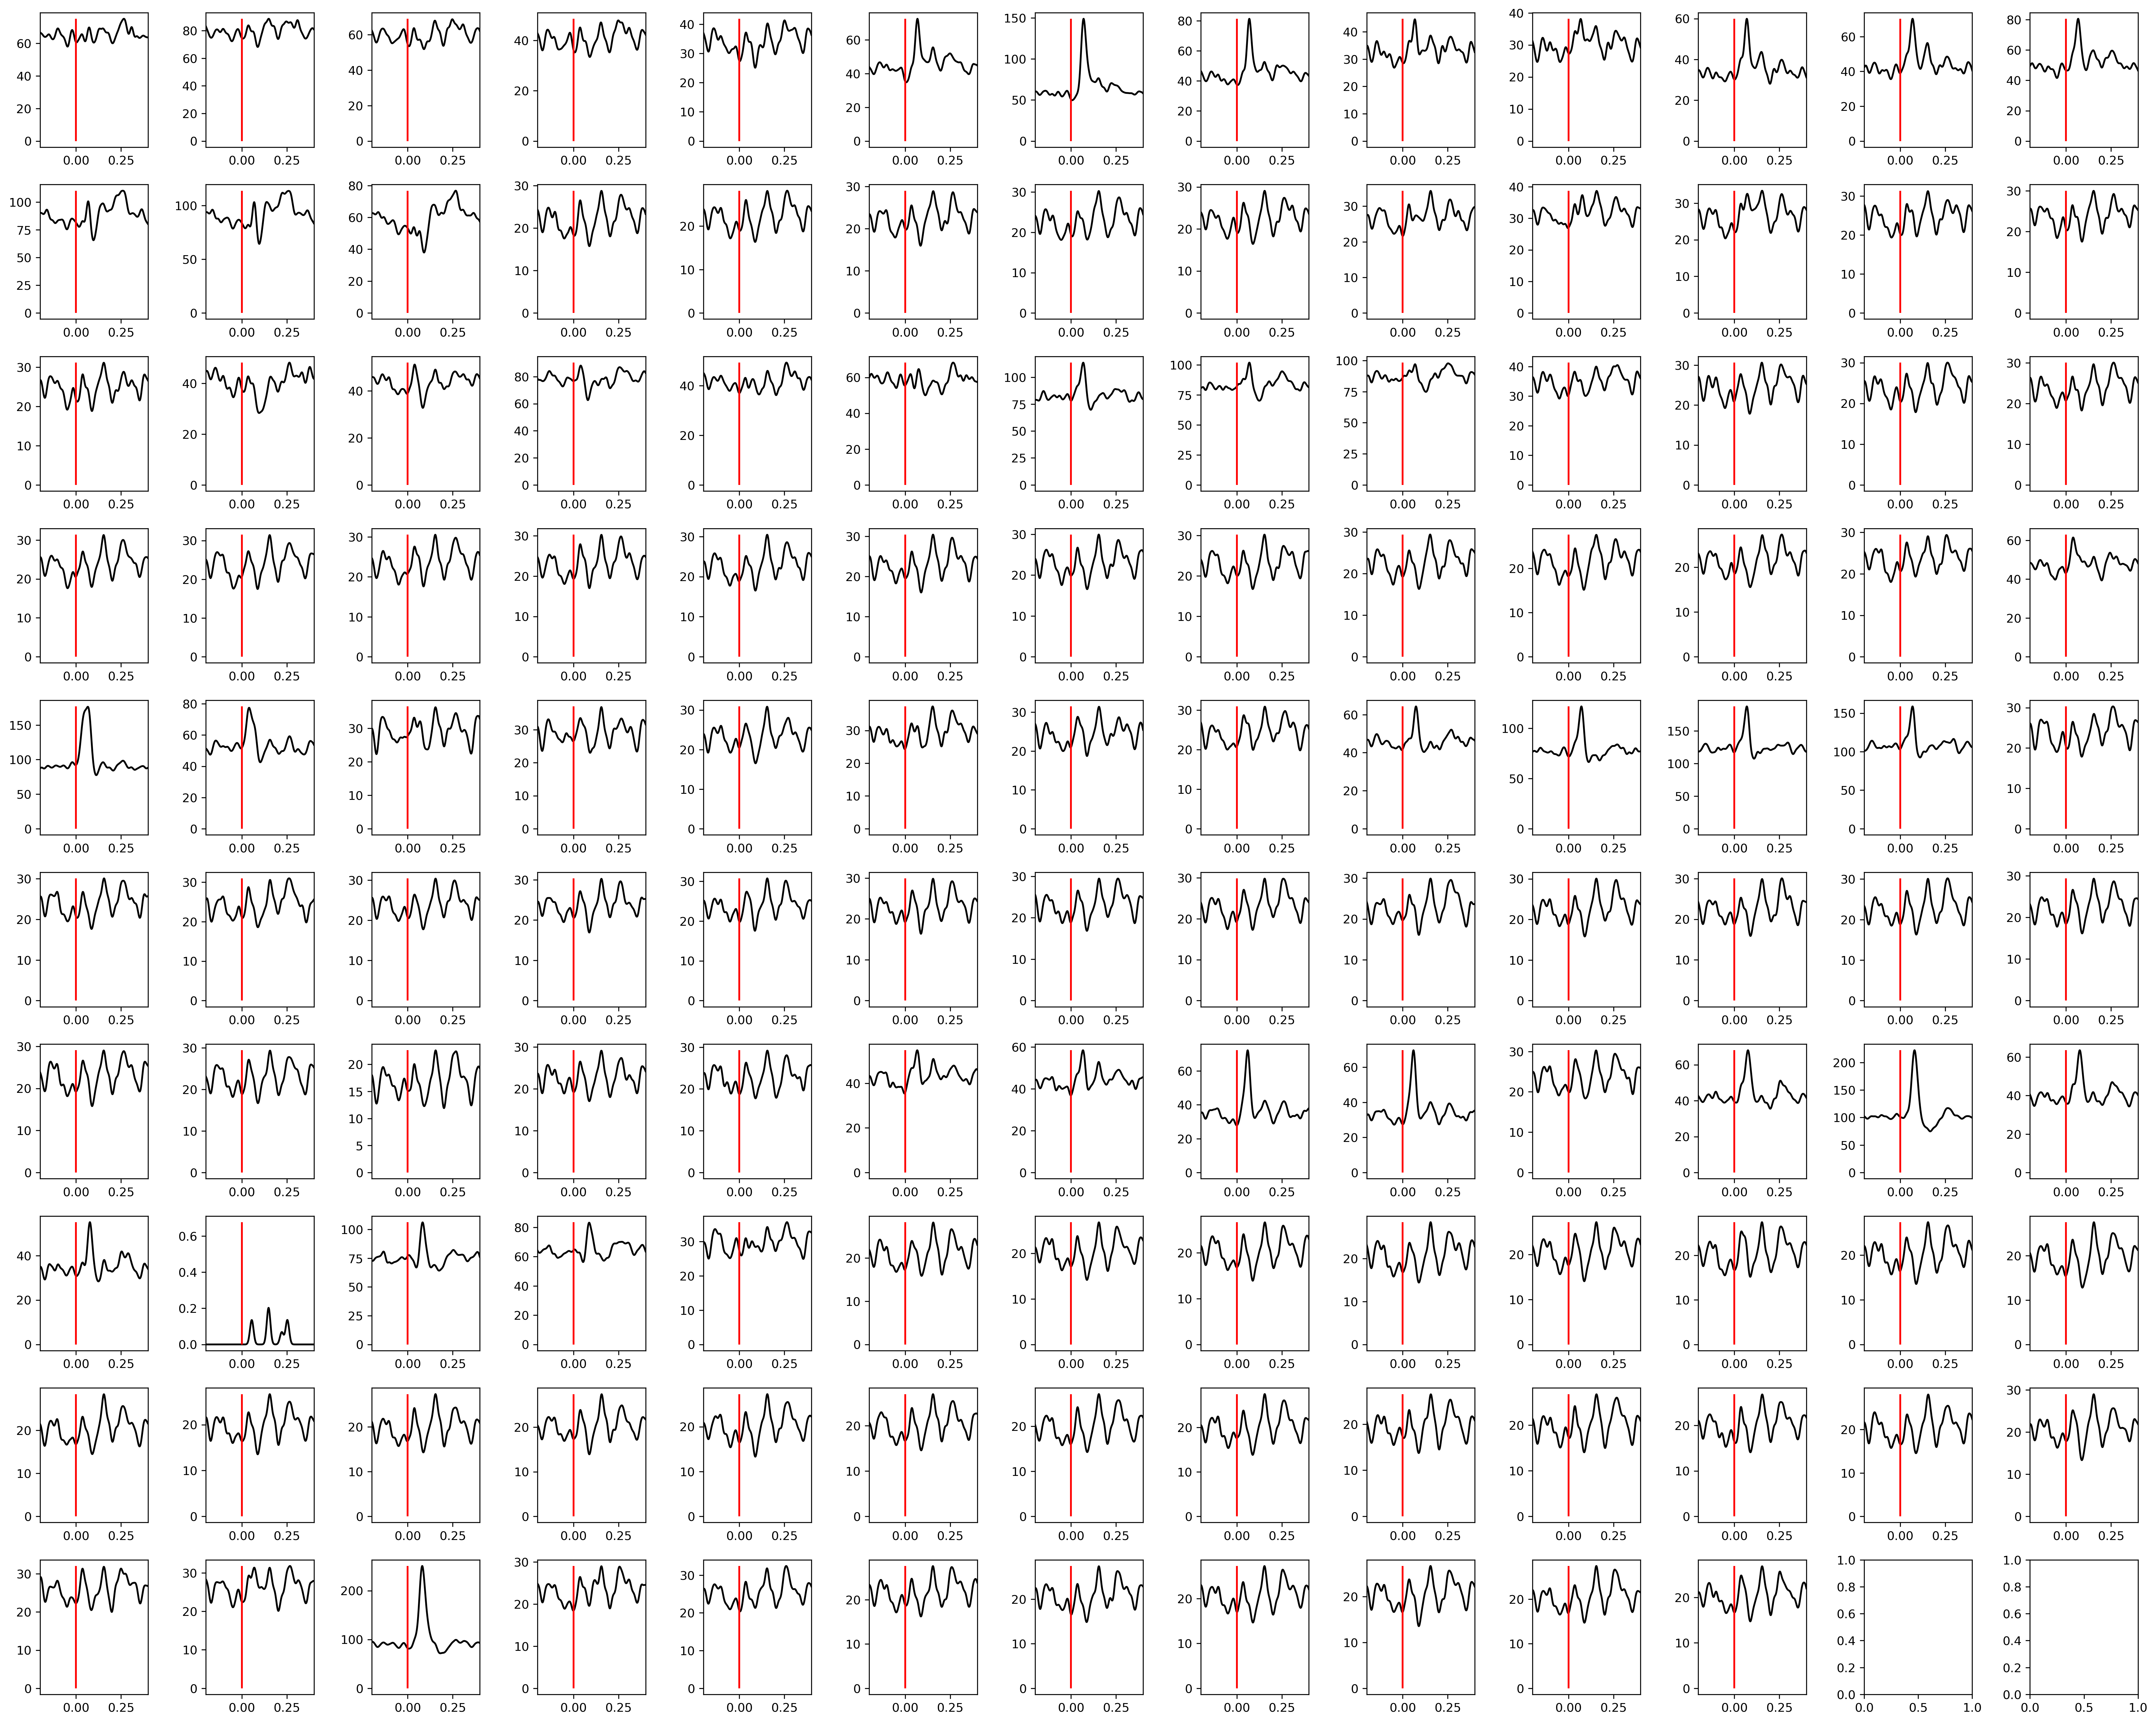

In [62]:
plt.subplots(10,13, figsize=(25,20), dpi=300)
for i in range(np.size(all_psth,0)):
    plt.subplot(10,13,i+1)
    plt.plot(psth_bins, all_psth[i,:], 'k')
    plt.xlim([-0.2,0.4])
    plt.vlines(0, 0, np.max(all_psth[i,:]), color='r')
plt.tight_layout()

In [ ]:
for i in range
plt.plot()

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(newtime1, ttl_onset-np.median(ttl_onset), label='ttl')
plt.plot(newtime1, filt_ephys[:,1]*30, label='lfp ch=1')
plt.plot(worldT[:-1]-t0, label_diff*30000, label='worldT')
plt.xlim([0.2, 0.3])
plt.legend()
plt.ylim([-40000,40000])

In [ ]:
f = onset_from_ttl[5]
ind = np.argmin(np.abs(f-(newtime1)))
startInd = ind-sz; endInd = ind+sz
startT = f-szT; endT = f+szT
sp[(sp>startT) & (sp<endT)]

In [ ]:
f = (eventT-t0)[5]
ind = np.argmin(np.abs(f-(newtime1)))
startInd = ind-sz; endInd = ind+sz
startT = f-szT; endT = f+szT
sp[(sp>startT) & (sp<endT)]

In [ ]:
start = 0
end = 3000000

ch = 2

plt.subplots(5,4,figsize=(10,10),dpi=200)

for i in range(20):
    plt.subplot(5,4,i+1)
    
    flipT = onset_from_ttl[i]
    
    win_start = flipT-0.15
    win_end = flipT+0.20

    plt.title('{} sec'.format(np.round(flipT,3)))
    
    # LFP
    plt.plot(newtime1[start:end], filt_ephys[start:end,ch], color='tab:blue')
    # plt.plot(newtime, ttl_onset)
    
    # TTL
    plt.plot(newtime1[start:end], (ttl_onset[start:end]-np.median(ttl_onset[start:end])), color='dimgrey', linewidth=1)

    plt.ylim([-1000, 1000])
    plt.xlim([win_start, win_end])

    plt.xticks(np.linspace(flipT-.15, flipT+.2, 5), labels=np.linspace(-150, 200, 5).astype(int))
    
    # Worldcam flipT
    wcT = eventT[np.argmin(np.abs((eventT-t0)-onset_from_ttl[i]))]-t0
    plt.vlines(wcT, -700, 700, color='k')
    
plt.tight_layout()

In [ ]:
np.linspace(-300, 300, 7)

In [ ]:
np.linspace(flipT-.3, flipT+.3, 7)

In [ ]:
i = 20
print('TTL={} worldcam={}'.format(onset_from_ttl[i],
        eventT[np.argmin(np.abs((eventT-t0)-onset_from_ttl[i]))]-t0))

In [ ]:
plt.plot(np.abs((eventT-t0)-100))

In [ ]:
wcT

In [ ]:
newtime[start:end].max()

In [ ]:
eventT[5]-t0

In [ ]:
ephys_df = pd.read_hdf('/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1/070921_J553RT_control_Rig2_fm1_ephys_props.h5')

In [ ]:
[x for x in ephys_df if 'T' in x]

In [ ]:
ephys_df.index.values

In [ ]:
row = ephys_df.iloc[31]

In [ ]:
row['spikeT'][:5]

In [ ]:
row['FmLt_imuT'].values[:5]

In [ ]:
row['FmLt_imuT'].shape

In [ ]:
row['FmLt_eyeT'][:5]

In [ ]:
row['FmLt_eyeT'].shape

In [ ]:
row['FmLt_topT'][:5]

In [ ]:
import json

In [ ]:
ephys_json = '/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1/070921_J553RT_control_Rig2_fm1_ephys_merge.json'

In [ ]:
with open(ephys_json, 'r') as fp:
    ephys = json.load(fp)

In [ ]:
ephys['spikeT']['0'][:5]

In [ ]:
ephys['t0']